# 02 — Feature Engineering (CTE)

**Goal:** turn the cleaned daily log into a **model-ready feature table** with reproducible, well-documented transforms.

Artifacts when finished:
- `data/interim/features.parquet` — feature matrix (one row per day)
- `notebooks/reports/feature_catalog.csv` — column list with dtypes & families
- `notebooks/reports/figures/prod_over_time_features.png` — quick target sanity plot

> Run this notebook **top-to-bottom** after Phase‑1 cleaning has produced `data/interim/clean.parquet`.


## 0) Setup & Project‑root detection

In [11]:
from __future__ import annotations
from pathlib import Path
import os, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# --- Locate repo root so paths are stable whether we run from / or /notebooks ---
here = Path.cwd()
if (here / "pyproject.toml").exists() and (here / "src").exists():
    ROOT = here
elif (here.parent / "pyproject.toml").exists():
    ROOT = here.parent
else:
    ROOT = here  # best effort fallback

print("Notebook CWD:", here)
print("Detected repo root:", ROOT)

DATA_DIR = ROOT / "data"
INTERIM_DIR = DATA_DIR / "interim"
SAMPLE_DIR = DATA_DIR / "sample"
REPORT_DIR = ROOT / "notebooks" / "reports"
FIG_DIR = REPORT_DIR / "figures"
REPORT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_PARQUET = INTERIM_DIR / "clean.parquet"
FEATURES_PARQUET = INTERIM_DIR / "features.parquet"
CATALOG_CSV = REPORT_DIR / "feature_catalog.csv"


Notebook CWD: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks
Detected repo root: /Users/deo/UMKC_phd/project_related/job_related/cte-project


## 1) Load cleaned data (with sample fallbacks)

In [12]:
def load_df():
    if CLEAN_PARQUET.exists():
        print(f"Loading: {CLEAN_PARQUET}")
        return pd.read_parquet(CLEAN_PARQUET)
    sample_parquet = SAMPLE_DIR / "clean_sample.parquet"
    sample_csv = SAMPLE_DIR / "cte_sample.csv"
    if sample_parquet.exists():
        print(f"Loading: {sample_parquet}")
        return pd.read_parquet(sample_parquet)
    if sample_csv.exists():
        print(f"Loading: {sample_csv}")
        return pd.read_csv(sample_csv)
    raise FileNotFoundError("No dataset found. Expected data/interim/clean.parquet or a sample in data/sample/.")

df = load_df().copy()
print(df.shape)
df.head(3)

Loading: /Users/deo/UMKC_phd/project_related/job_related/cte-project/data/interim/clean.parquet
(72, 56)


,date,wakeup_time_minutes,dinner_time_minutes,bed_time_minutes,sleep_duration_h,productivity_pct,deep_sleep_pct,rem_sleep_pct,water_drank_l,studied_at_home,...,reflection,primary_mood,secondary_mood,when_most_productive,interaction_partner,interaction_family,interaction_friends,dinner_time,bed_time,wakeup_time
0,2025-01-27,393,1240,1335,7.633333,75.0,21.0,8.0,1.5,1,...,I think i did good today for my first day on t...,motivated,happy,1,positive,na,na,8:40 PM,10:15 PM,6:33 AM
1,2025-01-28,443,1215,1320,9.100000,0.0,21.0,5.0,1.0,0,...,"Well, i did pretty bad today, couldn't get goi...",happy,overwhelmed,5,positive,positive,positive,8:15 PM,10:00 PM,7:23 AM
2,2025-01-29,370,1230,1339,7.933333,10.0,21.0,4.0,1.8,1,...,"i started good, maybe for first few minutes an...",overwhelmed,sad,1,positive,na,positive,8:30 PM,10:19 PM,6:10 AM


## 2) Helper utilities

In [13]:
def one_hot(series: pd.Series, prefix: str) -> pd.DataFrame:
    """One-hot encode a categorical series with a prefix (Int64 dtypes)."""
    cats = series.astype("category")
    oh = pd.get_dummies(cats, prefix=prefix, dummy_na=False)
    for c in oh:
        oh[c] = oh[c].astype("Int64")
    return oh

def add_cyclical_minutes(df: pd.DataFrame, col_minutes: str, period: int = 24*60) -> pd.DataFrame:
    """Append sin/cos encodings for a *_minutes column."""
    out = df.copy()
    if col_minutes in out.columns:
        x = out[col_minutes].astype(float)
        radians = 2 * math.pi * (x % period) / period
        out[f"{col_minutes}_sin"] = np.sin(radians)
        out[f"{col_minutes}_cos"] = np.cos(radians)
    return out

def add_lag_roll_features(df: pd.DataFrame, cols: list[str], lags=(1,3), rolls=(3,7)) -> pd.DataFrame:
    """For each col: add lag1/lag3, rolling mean(3/7), 7d z-score, 1d pct_change."""
    out = df.sort_values("date").copy()
    for c in cols:
        if c not in out: 
            continue
        s = out[c].astype(float)
        for L in lags:
            out[f"{c}_lag{L}"] = s.shift(L)
        for W in rolls:
            out[f"{c}_roll{W}"] = s.rolling(W, min_periods=max(2, W//2)).mean()
        mu7 = s.rolling(7, min_periods=3).mean()
        sd7 = s.rolling(7, min_periods=3).std()
        out[f"{c}_z7"] = (s - mu7) / sd7
        out[f"{c}_pct_change_1d"] = s.pct_change(1)
    return out

def catalog(df: pd.DataFrame) -> pd.DataFrame:
    import re
    def family(col):
        if col in {"date","dow","weekday_name","is_weekend","week_of_year","month"}: 
            return "calendar"
        if col.endswith("_minutes") or col.endswith("_minutes_sin") or col.endswith("_minutes_cos"):
            return "clock"
        if col.endswith("_lag1") or col.endswith("_lag3"):
            return "lag"
        if re.search(r"_roll(3|7)\b", col): 
            return "rolling_mean"
        if col.endswith("_z7"):             
            return "zscore_7d"
        if col.endswith("_pct_change_1d"):  
            return "pct_change_1d"
        if col.endswith("_no_interaction"):
            return "no_interaction_flag"
        if col.endswith("_score") or col == "interaction_total_score":
            return "interaction_score"
        if col.startswith(("breakfast_", "lunch_", "dinner_")):
            return "meal_onehot"
        if col.startswith("prod_"):
            return "productivity_onehot"
        if col in {"productivity_pct","sleep_duration_h","deep_sleep_pct","rem_sleep_pct","water_drank_l"}:
            return "core_numeric"
        if col in {"primary_mood","secondary_mood","when_most_productive_decoded"}:
            return "categorical"
        return "other"
    return pd.DataFrame({
        "column": df.columns,
        "dtype": [str(t) for t in df.dtypes],
        "family": [family(c) for c in df.columns],
    })

## 3) Calendar features

In [14]:
feat = df.copy()
if "date" in feat.columns:
    feat["date"] = pd.to_datetime(feat["date"])
    feat["dow"] = feat["date"].dt.dayofweek
    feat["weekday_name"] = feat["date"].dt.day_name()
    feat["is_weekend"] = feat["dow"].isin([5,6]).astype("Int64")
    feat["week_of_year"] = feat["date"].dt.isocalendar().week.astype(int)
    feat["month"] = feat["date"].dt.month.astype(int)
    dow_oh = pd.get_dummies(feat["dow"], prefix="dow", dtype="Int64")
    feat = pd.concat([feat, dow_oh], axis=1)
feat.head(3)

,date,wakeup_time_minutes,dinner_time_minutes,bed_time_minutes,sleep_duration_h,productivity_pct,deep_sleep_pct,rem_sleep_pct,water_drank_l,studied_at_home,...,is_weekend,week_of_year,month,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,2025-01-27,393,1240,1335,7.633333,75.0,21.0,8.0,1.5,1,...,0,5,1,1,0,0,0,0,0,0
1,2025-01-28,443,1215,1320,9.100000,0.0,21.0,5.0,1.0,0,...,0,5,1,0,1,0,0,0,0,0
2,2025-01-29,370,1230,1339,7.933333,10.0,21.0,4.0,1.8,1,...,0,5,1,0,0,1,0,0,0,0


## 4) Cyclical encodings for time-of-day

In [15]:
for minutes_col in ["wakeup_time_minutes","dinner_time_minutes","bed_time_minutes"]:
    if minutes_col in feat.columns:
        feat = add_cyclical_minutes(feat, minutes_col)
feat.filter(regex="(wakeup|dinner|bed)_time_minutes").head(3)

,wakeup_time_minutes,dinner_time_minutes,bed_time_minutes,wakeup_time_minutes_sin,wakeup_time_minutes_cos,dinner_time_minutes_sin,dinner_time_minutes_cos,bed_time_minutes_sin,bed_time_minutes_cos
0,393,1240,1335,0.989651,-0.143493,-0.766044,0.642788,-0.442289,0.896873
1,443,1215,1320,0.935135,-0.354291,-0.831470,0.555570,-0.500000,0.866025
2,370,1230,1339,0.999048,-0.043619,-0.793353,0.608761,-0.426569,0.904455


## 5) Meal quality one‑hots

In [16]:
# --- Meal quality one-hots (idempotent + dtype-safe) ---

MEAL_CATS = ["no_meal", "carb_heavy", "protein_heavy", "fat_heavy", "balanced"]

def ensure_meal_onehots(df: pd.DataFrame, meal_col: str) -> pd.DataFrame:
    """
    Create/normalize one-hots for a *_quality column (breakfast/lunch/dinner).
    - If all one-hots already exist (from cleaning), do not recreate.
    - If some are missing, create only the missing ones.
    - Map 'na' -> 'no_meal' for clarity/consistency.
    - Ensure Int64 dtype for all one-hot columns.
    """
    base = meal_col.replace("_quality", "")              # e.g. 'breakfast'
    expected = [f"{base}_{c}" for c in MEAL_CATS]        # e.g. breakfast_no_meal ...

    # If we have the raw quality column, normalize it (lower, strip, 'na'->'no_meal')
    if meal_col in df.columns:
        s = (df[meal_col].astype("string")
                        .str.strip()
                        .str.lower()
                        .replace({"na": "no_meal", "nan": pd.NA}))
    else:
        s = None

    # Case A: all expected one-hots already exist → just coerce dtype & return
    if all(c in df.columns for c in expected):
        for c in expected:
            # force pandas nullable integer for consistency
            if c in df.columns:
                df[c] = df[c].astype("Int64")
        return df

    # Case B: create only missing one-hots from the normalized source labels
    if s is not None:
        for cat in MEAL_CATS:
            colname = f"{base}_{cat}"
            if colname not in df.columns:
                df[colname] = (s == cat).astype("Int64")

        # For any still-missing cols (edge cases), add NA placeholder
        for colname in expected:
            if colname not in df.columns:
                df[colname] = pd.Series([pd.NA] * len(df), dtype="Int64")
    else:
        # No source labels and not all one-hots present: create NA placeholders
        for colname in expected:
            if colname not in df.columns:
                df[colname] = pd.Series([pd.NA] * len(df), dtype="Int64")

    # Final dtype pass
    for c in expected:
        df[c] = df[c].astype("Int64")
    return df

# Apply (idempotent)
feat = ensure_meal_onehots(feat, "breakfast_quality")
feat = ensure_meal_onehots(feat, "lunch_quality")
feat = ensure_meal_onehots(feat, "dinner_quality")

# Optional: drop the original string labels from the feature table
feat = feat.drop(columns=[c for c in ["breakfast_quality", "lunch_quality", "dinner_quality"] if c in feat.columns])

## 6) Productivity slot one‑hots (already created in cleaning)

In [17]:
keep = [c for c in feat.columns if c.startswith("prod_")]
feat[keep].head(3) if keep else feat.head(1)

,prod_morning,prod_afternoon,prod_evening,prod_none
0,1,0,0,0
1,0,0,0,1
2,1,0,0,0


## 7) Social interaction composites

In [18]:
scores = [c for c in ["partner_score","family_score","friends_score"] if c in feat.columns]
if scores:
    feat["interaction_total_score"] = feat[scores].sum(axis=1, min_count=1)

flags = [c for c in ["partner_no_interaction","family_no_interaction","friends_no_interaction"] if c in feat.columns]
if flags:
    feat["any_no_interaction"] = (feat[flags].fillna(0).sum(axis=1) > 0).astype("Int64")

feat[["interaction_total_score","any_no_interaction"]].head(5)

,interaction_total_score,any_no_interaction
0,1.0,1
1,3.0,0
2,2.0,1
3,1.0,1
4,0.0,1


## 8) Lags, rolling means, z‑scores, pct‑change

In [19]:
key = ["productivity_pct","sleep_duration_h","deep_sleep_pct","rem_sleep_pct","water_drank_l"]
feat = add_lag_roll_features(feat, key, lags=(1,3), rolls=(3,7))
feat.filter(regex="(pct|_lag|_roll|_z7)$").head(5)

,productivity_pct,deep_sleep_pct,rem_sleep_pct,productivity_pct_z7,sleep_duration_h_z7,deep_sleep_pct_z7,rem_sleep_pct_z7,water_drank_l_z7
0,75.0,21.0,8.0,NaN,NaN,NaN,NaN,NaN
1,0.0,21.0,5.0,NaN,NaN,NaN,NaN,NaN
2,10.0,21.0,4.0,-0.450200,-0.372839,NaN,-0.800641,0.907265
3,23.0,27.0,9.0,-0.119916,-0.388071,1.500000,1.050210,0.977162
4,5.0,25.0,15.0,-0.576724,-1.174592,0.707107,1.572491,0.805877


## 9) Minimal QA checks

In [20]:
expected = {
    "interaction_score": {"partner_score","family_score","friends_score","interaction_total_score"},
    "no_interaction_flag": {"partner_no_interaction","family_no_interaction","friends_no_interaction","any_no_interaction"},
    "meal_onehot": {"breakfast_no_meal","breakfast_carb_heavy","breakfast_protein_heavy","breakfast_fat_heavy","breakfast_balanced",
                    "lunch_no_meal","lunch_carb_heavy","lunch_protein_heavy","lunch_fat_heavy","lunch_balanced",
                    "dinner_no_meal","dinner_carb_heavy","dinner_protein_heavy","dinner_fat_heavy","dinner_balanced"},
    "lag": {"productivity_pct_lag1","sleep_duration_h_lag1"},
    "clock": {"dinner_time_minutes_sin","dinner_time_minutes_cos"},
    "calendar": {"date","dow"},
}
cat = catalog(feat)
ok = True
for fam, cols in expected.items():
    have = set(cat.loc[cat["family"]==fam, "column"])
    miss = cols - have
    print(f"{fam}: {'OK' if not miss else 'MISSING ' + str(miss)}")
    if miss: ok = False

nulls = feat.isna().mean().sort_values(ascending=False).head(10).round(3)
print("\nTop-10 null rates:\n", nulls)
assert ok, "Some expected feature families are missing — inspect the messages above."
print("\nQA: PASSED")

interaction_score: OK
no_interaction_flag: OK
meal_onehot: OK
lag: OK
clock: OK
calendar: OK

Top-10 null rates:
 rem_sleep_pct_lag3        0.042
water_drank_l_z7          0.042
deep_sleep_pct_lag3       0.042
sleep_duration_h_lag3     0.042
water_drank_l_lag3        0.042
productivity_pct_lag3     0.042
deep_sleep_pct_z7         0.042
productivity_pct_roll7    0.028
deep_sleep_pct_roll7      0.028
productivity_pct_z7       0.028
dtype: float64

QA: PASSED


# ensure unique columns 

In [21]:
feat = feat.loc[:, ~feat.columns.duplicated(keep="first")]

## 10) Save artifacts

Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/data/interim/features.parquet
Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/feature_catalog.csv


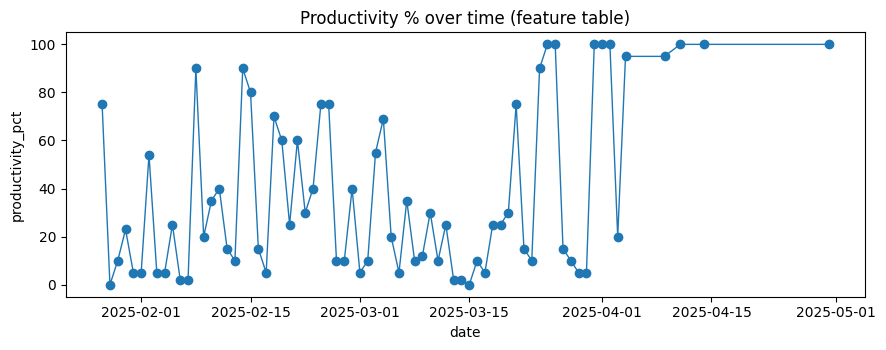

Wrote figure: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_over_time_features.png


In [22]:
INTERIM_DIR.mkdir(parents=True, exist_ok=True)
feat.to_parquet(FEATURES_PARQUET, index=False)
print("Wrote:", FEATURES_PARQUET)

cat = catalog(feat).sort_values(["family","column"]).reset_index(drop=True)
cat.to_csv(CATALOG_CSV, index=False)
print("Wrote:", CATALOG_CSV)

if "date" in feat and "productivity_pct" in feat:
    plt.figure(figsize=(9, 3.6))
    feat = feat.sort_values("date")
    plt.plot(feat["date"], feat["productivity_pct"], marker="o", lw=1)
    plt.title("Productivity % over time (feature table)")
    plt.xlabel("date")
    plt.ylabel("productivity_pct")
    out = FIG_DIR / "prod_over_time_features.png"
    plt.tight_layout()
    plt.savefig(out, dpi=150)
    plt.show()  # <— actually show it in the notebook
    print("Wrote figure:", out)

## 11) Final peek

In [23]:
print("Shape:", feat.shape)
display(feat.head(3))

import pandas as pd
pd.set_option("display.max_rows", 200)
display(cat.head(30))
print("\nFamilies:", cat["family"].value_counts().to_dict())

Shape: (72, 103)


,date,wakeup_time_minutes,dinner_time_minutes,bed_time_minutes,sleep_duration_h,productivity_pct,deep_sleep_pct,rem_sleep_pct,water_drank_l,studied_at_home,...,rem_sleep_pct_roll3,rem_sleep_pct_roll7,rem_sleep_pct_z7,rem_sleep_pct_pct_change_1d,water_drank_l_lag1,water_drank_l_lag3,water_drank_l_roll3,water_drank_l_roll7,water_drank_l_z7,water_drank_l_pct_change_1d
0,2025-01-27,393,1240,1335,7.633333,75.0,21.0,8.0,1.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-28,443,1215,1320,9.100000,0.0,21.0,5.0,1.0,0,...,6.500000,NaN,NaN,-0.375,1.5,NaN,1.250000,NaN,NaN,-0.333333
2,2025-01-29,370,1230,1339,7.933333,10.0,21.0,4.0,1.8,1,...,5.666667,5.666667,-0.800641,-0.200,1.0,NaN,1.433333,1.433333,0.907265,0.800000


,column,dtype,family
0,date,datetime64[ns],calendar
1,dow,int32,calendar
2,is_weekend,Int64,calendar
3,month,int64,calendar
4,week_of_year,int64,calendar
5,weekday_name,object,calendar
6,primary_mood,string,categorical
7,secondary_mood,string,categorical
8,when_most_productive_decoded,category,categorical
9,bed_time_minutes,int64,clock



Families: {'other': 22, 'meal_onehot': 16, 'lag': 10, 'rolling_mean': 10, 'clock': 9, 'calendar': 6, 'core_numeric': 5, 'pct_change_1d': 5, 'zscore_7d': 5, 'interaction_score': 4, 'no_interaction_flag': 4, 'productivity_onehot': 4, 'categorical': 3}
